In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [504]:
import sys
sys.path.append('../slip_rate_tools/')
import numpy as np
import slip_rate_tools.slip_rate_tools as srt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools


In [274]:
np.random.seed(420)

In [321]:
x_data = np.array([15, 73, 125, 200, 266, 277])
#x_data = x_data[1:]
breakpt = 125
breaks = np.array([0, breakpt, 200])

exog = np.column_stack([np.maximum(0, x_data - knot) 
                        for knot in breaks])

#exog

In [329]:
# make y data
slopes = np.array([1., -2., 1.])
y_true = np.dot(exog, slopes)

y_obs = y_true + x_data * np.random.randn(len(x_data)) * 0.2

#y_obs = y_true

#y_obs = y_true + 100

In [330]:
np.linalg.lstsq(exog, y_true)[0]

array([ 1., -2.,  1.])

In [541]:
def flatten(nested_iterator):
    for item in nested_iterator:
        if not hasattr(item, 'len'):
            item = [item]
    print(nested_iterator)
    return list(itertools.chain(*nested_iterator))

def fit_piecewise(x_data, y_data, breakpts):
    if hasattr(breakpts, 'shape'):
        breakpts = breakpts.tolist()
    else:
        breakpts = list(breakpts)
    breakpts.insert(0, 0)
    
    exog = np.column_stack([np.maximum(0, x_data - knot)
                           for knot in breakpts])
    
    slopes, sum_resid = np.linalg.lstsq(exog, y_data)[0:2]
    
    return np.cumsum(slopes), sum_resid
    

def piecewise_search(x_data, y_data, n_pieces=2, n_iters=100):
    
    n_breaks = n_pieces -1
    breakpt_samples = np.random.uniform(0., x_data.max(), (n_iters, n_breaks))
    breakpt_samples = np.sort(breakpt_samples, axis=1)
    slopes = {}
    sumsqs = np.ones(n_iters) * np.inf
    
    for i, breakpt in enumerate(breakpt_samples):
        try:
            slopes[i], sumsqs[i] = fit_piecewise(x_data, y_data, breakpt)
        except ValueError:
            #print('this broke: ', fit_piecewise(x_data, y_data, breakpt))
            pass
        
    ii = np.argmin(sumsqs)
        
    return flatten([slopes[ii], breakpt_samples[ii], sumsqs[ii]])

In [542]:
flatten([[4,5],6])

[[4, 5], 6]


TypeError: 'int' object is not iterable

In [ ]:
np.argmin()

In [176]:
%%timeit
np.linalg.lstsq(exog, y_true)

10000 loops, best of 3: 97.9 µs per loop


In [338]:
#%%timeit
fit_piecewise(x_data, y_true, [175])

(array([ 0.68716942, -0.79313895]), array([ 4732.4563945]))

In [535]:
#%%timeit
piecewise_search(x_data, y_true, n_iters=20, n_pieces=2)

[array([ 0.98744347, -0.47168234]), array([ 117.36727243]), 993.02998173288188]

In [476]:
#%%timeit
res = sm.OLS(y_obs, exog).fit()

In [288]:
m1, m2, brk, sumsq = piecewise_search_1(x_data, y_obs, 10)
print(m1, m2, brk)

1.12605007616 -0.299729025002 139.466373765


In [283]:
%%timeit
piecewise_search_2(x_data, y_true, n=10)

1000 loops, best of 3: 1.3 ms per loop


In [187]:
%%timeit
piecewise_search_3(x_data, y_true, n=100)

The slowest run took 24.18 times longer than the fastest. This could mean that an intermediate result is being cached 
1 loops, best of 3: 12.9 ms per loop


In [477]:
res.summary()

/Users/itchy/src/anaconda/lib/python3.4/site-packages/statsmodels/stats/stattools.py:72: UserWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.601
Method:                 Least Squares   F-statistic:                     4.008
Date:                Fri, 31 Jul 2015   Prob (F-statistic):              0.142
Time:                        09:19:32   Log-Likelihood:                -28.565
No. Observations:                   6   AIC:                             63.13
Df Residuals:                       3   BIC:                             62.51
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.6135      0.275      2.233      0.112        -0.261     1.488
x2            -0.7049      0.904     -0.780      0.493        -3.583     2.173
x3            -0.0956      1.240     -0.077      0.943        -4.042     3.850
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   2.694
Prob(Omnibus):                    nan   Jarque-Bera (JB):                0.277
Skew:                          -0.526   Prob(JB):                        0.871
Kurtosis:                       3.001   Cond. No.                         18.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [478]:
res.params

array([ 0.61346394, -0.70490376, -0.09563569])

In [227]:
xx = np.arange(x_data.max())

In [290]:
y_fit_perfect = srt.piecewise_linear(xx, breakpt, 
                                     *(res.params[0], res.params[0]+res.params[1]))
y_fit_est = srt.piecewise_linear(xx, brk, m1, m2)

In [297]:
#%%timeit
sumsum = sum((srt.piecewise_linear(x_data, brk, m1, m2) - y_obs)**2)

print((sumsum - sumsq) / sumsum)

0.00555800199988


In [313]:
npsqs, srsqs = np.zeros(1000), np.zeros(1000)

for i in range(1000):
    xxx = np.random.uniform(0, 100, 5)
    yyy = np.random.uniform(0, 200, 5)
    
    mm1, mm2, bk, npsq = piecewise_search_1(xxx, yyy, n=100)
    
    srsq = ((yyy - srt.piecewise_linear(xxx, bk, mm1, mm2))**2).sum()
    
    npsqs[i] = npsq
    srsqs[i] = srsq
    
    

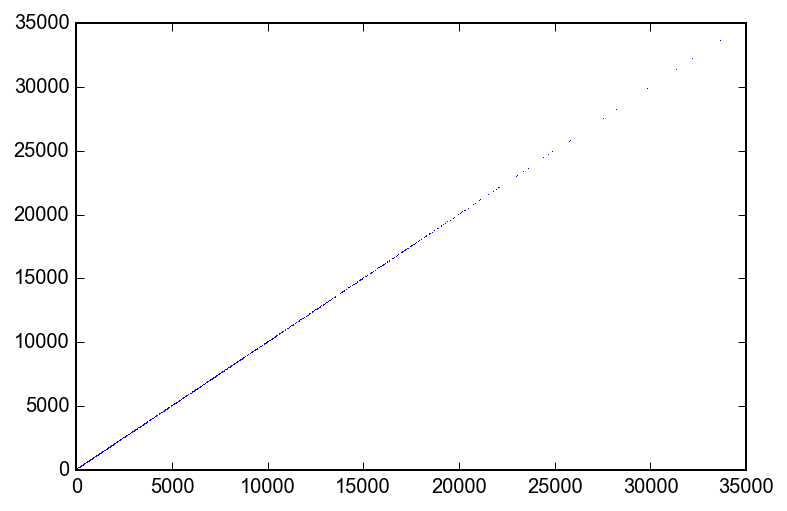

In [314]:
plt.plot(npsqs, srsqs, ',')

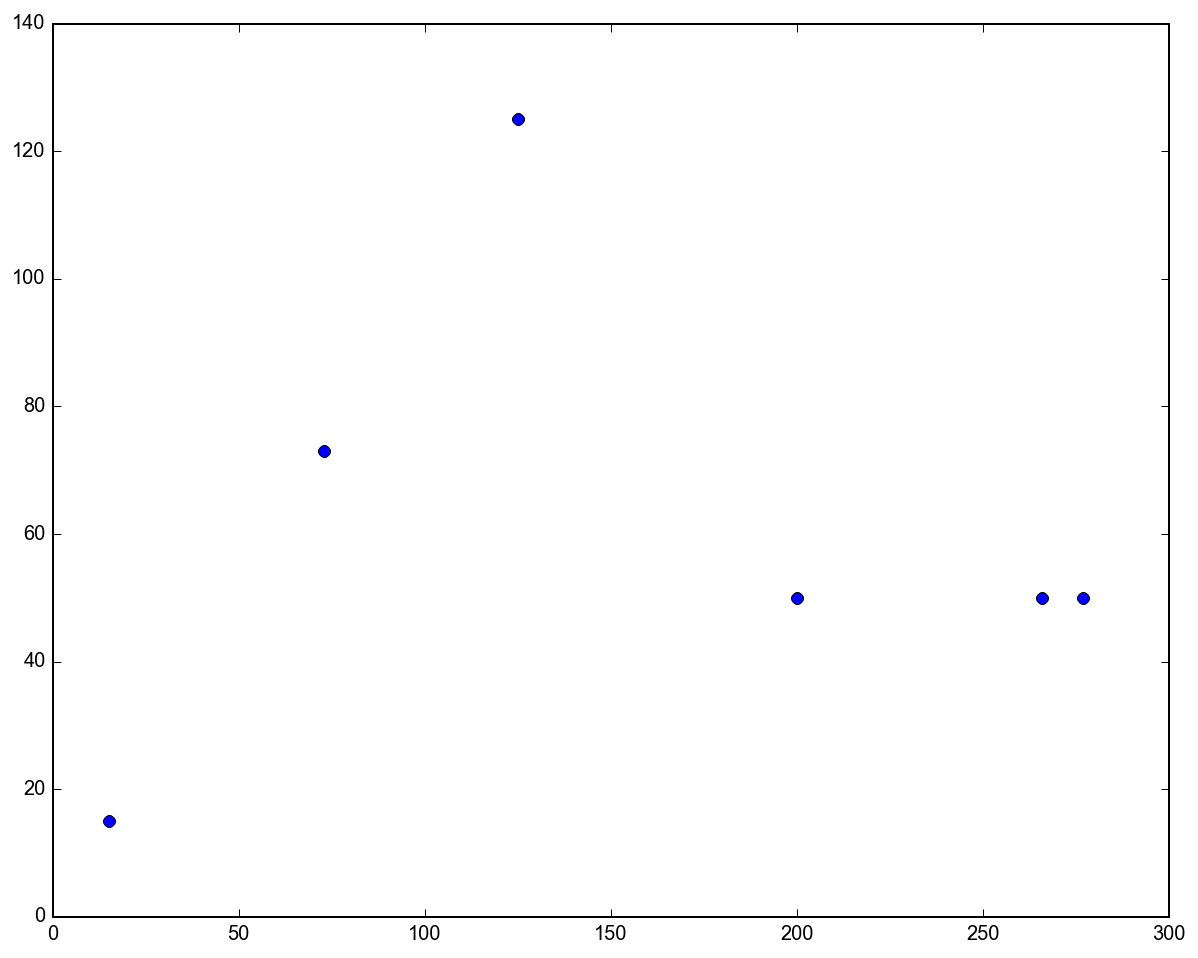

In [471]:
plt.figure(figsize=(10,8))

plt.plot(x_data, y_true, 'o')
#plt.plot(x_data, y_obs, 'o')
#plt.plot(xx, y_fit_perfect, 'k--')
#plt.plot(xx, y_fit_est, 'r--')


In [100]:
[0, x_data]

[0, array([ 73, 125, 200, 266, 277])]

In [133]:
x_data.tolist().insert(0,0)

In [134]:
x_data

array([ 15,  73, 125, 200, 266, 277])

In [135]:
x_data.tolist()

[15, 73, 125, 200, 266, 277]

In [136]:
xl = x_data.tolist()

In [138]:
xl.insert(0,0)

In [139]:
xl

[0, 15, 73, 125, 200, 266, 277]

In [498]:
xl

[[9, 9, 9], [9, 9, 9], 0, 15, 73, 125, 200, 266, 277]

In [497]:
x2 = xl.insert(0, [9, 9, 9])

In [495]:
x2

In [496]:
print(x2)

None


In [527]:
### irrelevant stuff about results columns; need to fix varous functions in srt before
### arbitrary n_pieces will really work

### mostly returning breakpts!


def make_linear_results_columns(fit_type=None, n_linear_pieces=None):    
    if fit_type == 'piecewise':
        if n_linear_pieces == 2:
            results_columns = ['m1', 'm2', 'breakpt', 'sumsq2', 'm', 'sumsq1']
        else:
            raise Exception('Only 2 piece piecewise-linear fits supported')
    elif fit_type == 'linear':
        results_columns = ['m', 'sumsq1']

    return results_columns


def make_linear_results_columns(fit_type=None, n_linear_pieces=None):    
    results_columns = ['m', 'sumsq1']
    
    if fit_type == 'piecewise':
        
        m_cols = ['m{}'.format(num + 1) for num in range(n_linear_pieces)]
        
        results_columns = flatten([m_cols, ['breakpt', 'sumsq2'], results_columns])

    return results_columns

In [529]:
make_linear_results_columns(fit_type='piecewise', n_linear_pieces=3)

['m1', 'm2', 'm3', 'breakpt', 'sumsq2', 'm', 'sumsq1']

In [531]:
[i for i in range(3)]

[0, 1, 2]